In [1]:
import pyodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from sklearn.decomposition import PCA
from collections import Counter

from sqlalchemy import create_engine
from urllib.parse import quote


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

# nltk.download('vader_lexicon')
# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
# Define connection parameters
server = 'localhost'
database = 'BritishAirwaysDB'
driver = 'ODBC Driver 17 for SQL Server'

# Connection string
connection_string = f"mssql+pyodbc:///?odbc_connect={quote(f'DRIVER={{{driver}}};SERVER={server};DATABASE={database};Trusted_Connection=yes;')}"

try:
    # Establish a connection using pyodbc
    connection = pyodbc.connect(f'DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;')
    print("Connected successfully to the database.")

    # Execute a simple query to ensure everything is working
    cursor = connection.cursor()
    cursor.execute("SELECT @@version;")
    row = cursor.fetchone()
    if row:
        print("Database version:", row[0])

except pyodbc.Error as e:
    print("Error in connection:", e)

finally:
    # Close the connection when established
    if 'connection' in locals() and connection:
        connection.close()

# Create a SQLAlchemy engine
engine = create_engine(connection_string)

# Query the table
query = "SELECT * FROM Reviews"
OpenFile = pd.read_sql(query, engine)


Connected successfully to the database.
Database version: Microsoft SQL Server 2022 (RTM) - 16.0.1000.6 (X64) 
	Oct  8 2022 05:58:25 
	Copyright (C) 2022 Microsoft Corporation
	Developer Edition (64-bit) on Windows 10 Home Single Language 10.0 <X64> (Build 26100: ) (Hypervisor)



In [4]:

# Show First ten
OpenFile = OpenFile
FirstTen = OpenFile.head(4)
FirstTen

,Id,Rating,Author,Author Location,Review Date,Review Title,Review,Type Of Traveller,Seat Type,Route,Date Flown,Seat Comfort,Cabin Staff Service,Food And Beverages,Inflight Entertainment,Ground Service,Value For Money,Recommended Service
0,1,1.0,Bart Johnson,United States,2025-01-05,Not the best customer service,✅ Trip Verified | Not the best customer serv...,Couple Leisure,Economy Class,Monrovia to Washington via Addas Ababa,2025-01-01,1.0,3.0,1.0,0.0,2.0,2,no
1,2,2.0,H Thornton,United States,2025-01-03,Worst business class experience,✅ Trip Verified | Worst business class experie...,Business,Business Class,Addis Ababa to Toronto via Rome,2025-01-01,2.0,1.0,1.0,1.0,2.0,3,no
2,3,3.0,I Lee,United States,2024-12-17,the toilets became dirty,✅ Trip Verified | Towards the end of the fli...,Business,Economy Class,Addis Ababa to Nairobi,2024-12-01,1.0,1.0,3.0,0.0,3.0,3,no
3,4,1.0,Brenda Acan,United States,2024-12-16,Worst service ever,✅ Trip Verified | Worst service ever. Beside d...,Couple Leisure,Economy Class,Dubai to Zanzibar via Ethiopia,2024-12-01,1.0,1.0,1.0,1.0,1.0,1,no


In [7]:
# Define Business Categories:

# Failing: Extremely low ratings.
# Needs Improvement: Below average.
# Satisfactory: Average ratings.
# Exceeding Expectations: Above average.
# Exceptional: High ratings.

In [9]:
# Data preprocessing

OpenFile['Review Date'] = pd.to_datetime(OpenFile['Review Date'])

In [11]:
# Sentiment analysis

sa = SentimentIntensityAnalyzer()
OpenFile['Sentiment Score'] = OpenFile['Review'].apply(lambda x: sa.polarity_scores(x)['compound'])

In [12]:
# 1: For us to quantify emotions in the reviews we used Sentiment Analysis. 
# Why? = Passenger's emotional reaction strongly correlates with their overall experience and Raw data alone is not enough.



In [14]:

# Feature engineering

OpenFile['Average Service Rating'] = OpenFile[['Seat Comfort', 'Cabin Staff Service', 'Food And Beverages', 'Inflight Entertainment', 'Ground Service']].mean(axis=1)
# Factors such as non-textual factors like services rates ['Seat Comfort', 'Cabin Staff Service', 'Food And Beverages', 'Inflight Entertainment', 'Ground Service'] etc aggregates rating

In [16]:
# One-hot encode categorical variables

#OpenFile = pd.get_dummies(OpenFile, columns=['Type Of Traveller', 'Seat Type'], drop_first=True)
# Convert categorical columns to numerical

le = LabelEncoder()
OpenFile['Type Of Traveller'] = le.fit_transform(OpenFile['Type Of Traveller'])
OpenFile['Seat Type'] = le.fit_transform(OpenFile['Seat Type'])
OpenFile['Recommended Service'] = le.fit_transform(OpenFile['Recommended Service'])

In [19]:
# Prepare the data for model training
X = OpenFile.drop(['Rating', 'Value For Money', 'Recommended Service', 'Id', 'Author', 'Review Date', 'Review Title', 'Review', 'Author Location', 'Route', 'Date Flown'], axis=1)
Y = OpenFile['Recommended Service'].astype(int)  # Ensure the binary classification

In [25]:
# Data Modeling

In [26]:
# Train-test split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [27]:
# Model training with the application of hyperparameter tuning

param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, Y_train)

# For us to understand what impacts Passenger recommendations, we train a Random Forest Classifier using features such as ['Seat Comfort', 'Cabin Staff Service', 'Food And Beverages', 'Inflight Entertainment', 'Ground Service']

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [100, 200]},
             scoring='accuracy')

In [36]:
# Evaluation

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92        55
           1       0.87      0.84      0.85        31

    accuracy                           0.90        86
   macro avg       0.89      0.88      0.89        86
weighted avg       0.89      0.90      0.89        86



In [37]:
# The classification report gives us insights into how well the model predicts whether passenges will recommend the airline’s service (Recommended Service = 1) or not recommend it (Recommended Service = 0).
# The model correctly classifies 90% of the reviews (either as recommendations or non-recommendations).


# precision means that when the model predicts a review will be a "recommendation" (1), it is correct 87% of the time. Similarly, when it predicts "not recommended" (0), it is 91% correct.

# 93% recall for class 0 means the model identifies most negative reviews correctly.
# 84% recall for class 1 means some positive recommendations are missed.

# F1-score of 0.92 for negative reviews means it's highly reliable at catching dissatisfied passengers.
# F1-score of 0.85 for positive reviews is slightly lower, meaning the model could be improved in detecting true positive recommendations.

In [41]:
# Visualization

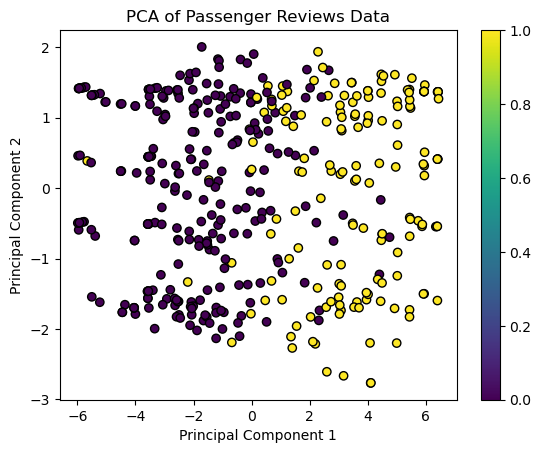

In [42]:
# Dimensionality Reduction: Passenger Segments: to See Distinct Groups
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='viridis', edgecolor='k')
plt.title('PCA of Passenger Reviews Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

In [43]:
# REsults: 

# To investigate Passenger behaviors, we can apply Principal Component Analysis (PCA) to reduce high-dimensional data into two main components.
# The scatter plot visualizes passenger data in two dimensions:
    # Clusters of yellow dots represent highly satisfied passengers.
    # Scattered dark purple dots may indicate neutral or unhappy passengers

# passengers naturally form distinct groups based on the chart — some are highly satisfied, while others have mixed or negative experiences.

In [45]:
# Feature Importance
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

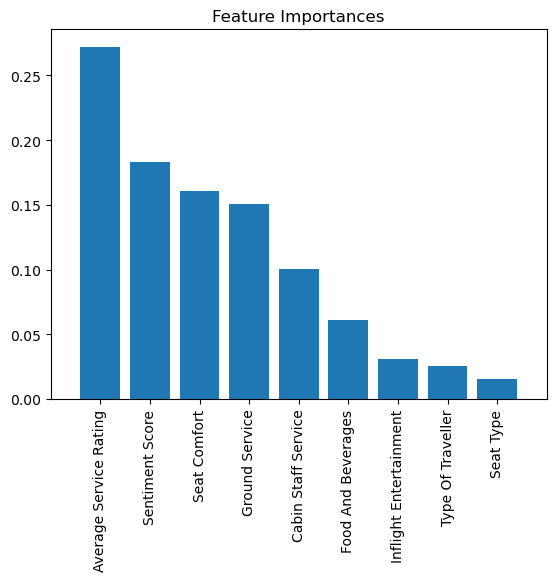

In [47]:
# Plotting Feature Importances
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

In [48]:
# Results: Key Finding:

# Charts reveals that Services quality is the stronges predictor of passenger satisfaction more than seat types or traveller type,
# "Average Service Rating" dominates (highest bar in the left chart), proving that overall service experience is crucial.
# "Sentiment Score" is also key, reinforcing that emotions in reviews align with recommendations.



In [50]:
# Business Recommendations:

# Invest in service quality: The airline should prioritize improving service quality rather than focusing on ticket class or traveler type to shift more passengers into the high-satisfaction group.
# Use data to personalize experiences: Identifying distinct Passenger clusters can help tailor services to different groups.
# Monitor and improve Passenger sentiment: Negative sentiment correlates with poor recommendations.

In [53]:
# Part 2: Further Analysis

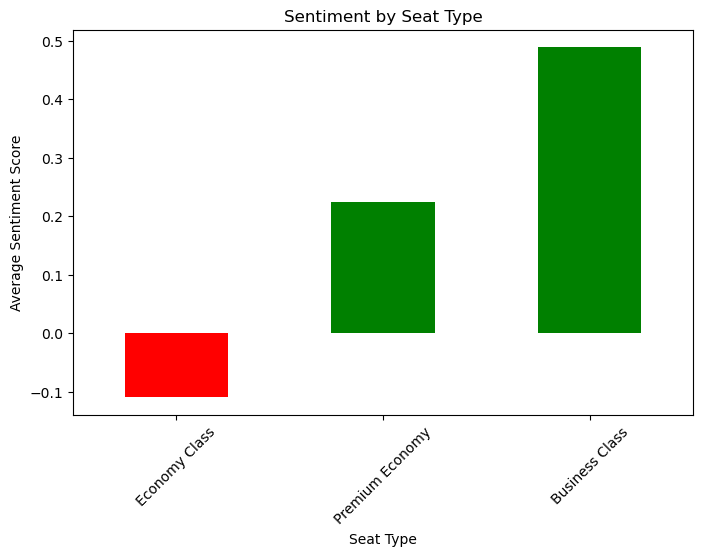

In [55]:
# Sentiment Trend Analysis by Service Type: which service type (economy, business, first-class) has the most complaints.

# Define a mapping dictionary for seat types
seat_type_mapping = {
    1: "Economy Class",
    2: "Premium Economy",
    3: "Business Class",
    4: "First Class"
}

# Replace numerical seat types with names
OpenFile['Seat Type'] = OpenFile['Seat Type'].map(seat_type_mapping)

# Group by Seat Type and calculate average sentiment score
sentiment_by_seat = OpenFile.groupby('Seat Type')['Sentiment Score'].mean().sort_values()

# Plot sentiment by seat type
plt.figure(figsize=(8, 5))
sentiment_by_seat.plot(kind='bar', color=['red' if x < 0 else 'green' for x in sentiment_by_seat])
plt.ylabel('Average Sentiment Score')
plt.title('Sentiment by Seat Type')
plt.xticks(rotation=45)

# Show plot with proper seat type names
plt.show()



In [59]:
# RESULTS: to continue




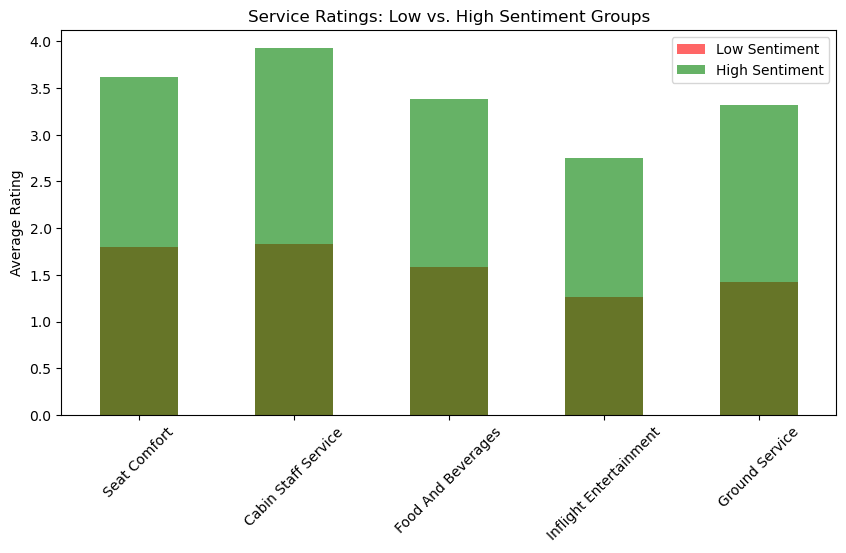

In [68]:
# Compare Low  (negative reviews) vs. High Sentiment Groups  (positive reviews) on average service ratings to find areas of improvement.


# Define thresholds for low and high sentiment
low_sentiment = OpenFile[OpenFile['Sentiment Score'] < -0.3]
high_sentiment = OpenFile[OpenFile['Sentiment Score'] > 0.3]

# Compare service categories
service_columns = ['Seat Comfort', 'Cabin Staff Service', 'Food And Beverages', 'Inflight Entertainment', 'Ground Service']

low_avg = low_sentiment[service_columns].mean()
high_avg = high_sentiment[service_columns].mean()

# Create comparison plot
fig, ax = plt.subplots(figsize=(10, 5))
low_avg.plot(kind='bar', color='red', alpha=0.6, label='Low Sentiment')
high_avg.plot(kind='bar', color='green', alpha=0.6, label='High Sentiment')
plt.ylabel('Average Rating')
plt.title('Service Ratings: Low vs. High Sentiment Groups')
plt.legend()
plt.xticks(rotation=45)
plt.show()



In [72]:
# RESULTS: to continue